# Load & Info & Data Preprocessing

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the sessions dataset
X = pd.read_csv('../data/train_merge_tfidf.csv')
y = pd.read_csv('../data/y.csv')

## selector3

In [101]:
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest

# SelectKBest: est une methode de sélection de caractéristiques qui permet de sélectionner les K meilleures caractéristiques
# en fonction d'un test statistique 
selector3 = SelectKBest(f_classif, k=23)
selector3.fit(X, y)

selected_feature_indices = selector3.get_support(indices=True)

selected_feature_names = X.columns[selected_feature_indices]

print(selected_feature_names)

C:\Users\ayoub\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ayoub\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [5 8] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\ayoub\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Index(['1', '2', '11', '12', '13', '76', '87', '128', '197', '246', '296',
       '320', '337', '376', '389', '394', '397', '433', '462', '473', '475',
       '479', '522'],
      dtype='object')


# Selected

In [102]:
selected_feature_names

Index(['1', '2', '11', '12', '13', '76', '87', '128', '197', '246', '296',
       '320', '337', '376', '389', '394', '397', '433', '462', '473', '475',
       '479', '522'],
      dtype='object')

In [103]:
X = X[selected_feature_names]

In [104]:
X = X[:20000]
y = y[:20000]

In [105]:
X.shape

(20000, 23)

In [106]:
y.shape

(20000, 1)

In [107]:
from sklearn.metrics import make_scorer

# https://www.kaggle.com/davidgasquez/ndcg-scorer

def dcg_score(y_true, y_score, k=5):
    
    """Discounted cumulative gain (DCG) at rank K.

    Parameters
    ----------
    y_true : array, shape = [n_samples]
        Ground truth (true relevance labels).
    y_score : array, shape = [n_samples, n_classes]
        Predicted scores.
    k : int
        Rank.

    Returns
    -------
    score : float
    """
    
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)


def ndcg_score(ground_truth, predictions, k=5):
    
    """Normalized discounted cumulative gain (NDCG) at rank K.

    Normalized Discounted Cumulative Gain (NDCG) measures the performance of a
    recommendation system based on the graded relevance of the recommended
    entities. It varies from 0.0 to 1.0, with 1.0 representing the ideal
    ranking of the entities.

    Parameters
    ----------
    ground_truth : array, shape = [n_samples]
        Ground truth (true labels represended as integers).
    predictions : array, shape = [n_samples, n_classes]
        Predicted probabilities.
    k : int
        Rank.

    Returns
    -------
    score : float

    Example
    -------
    >>> ground_truth = [1, 0, 2]
    >>> predictions = [[0.15, 0.55, 0.2], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]
    >>> score = ndcg_score(ground_truth, predictions, k=2)
    1.0
    >>> predictions = [[0.9, 0.5, 0.8], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]
    >>> score = ndcg_score(ground_truth, predictions, k=2)
    0.6666666666
    """
    
    lb = LabelBinarizer()
    lb.fit(range(predictions.shape[1] + 1))
    T = lb.transform(ground_truth)

    scores = []

    # Iterate over each y_true and compute the DCG score
    for y_true, y_score in zip(T, predictions):
        actual = dcg_score(y_true, y_score, k)
        best = dcg_score(y_true, y_true, k)
        score = float(actual) / float(best)
        scores.append(score)

    return np.mean(scores)


# NDCG Scorer function
ndcg_scorer = make_scorer(ndcg_score, needs_proba=True, k=5)

# Fiting

In [108]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
import xgboost as xgb

param_grid = {
'max_depth': sp_randint(3, 20),
'learning_rate': [0.001, 0.01, 0.1, 0.2],
'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
'min_child_weight': [0.25,0.5, 1.0, 3.0, 5.0, 7.0],
'gamma': [0, 0.25, 0.3,0.35,0.45,0.5,0.6,0.8,1.0],
'reg_lambda': [0.1,0.2,0.4,0.5,0.6,0.8,1.0,10.0],
'n_estimators':[100,200,500,1000,2000],
'colsample_bytree':[0.1,0.3,0.5,1],
'colsample_bylevel':[0.1,0.3,0.5,1]
}


gb = xgb.XGBClassifier(objective='multi:softmax',eval_metric= 'mlogloss')

clf = RandomizedSearchCV(gb, param_grid,n_jobs=-1,verbose=10,scoring=ndcg_scorer, random_state=42)

In [109]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

y_target = le.fit_transform(y['target_column_name'])

y_target

array([11,  7,  7, ...,  7,  7,  7])

In [110]:
clf.fit(X,y_target)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='mlogloss',
                                           feature_types=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rat...
                                                          0.2],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001C481AB4AC0>,
                                        'min_child_weight': [0.25, 0.5, 1.0,
                                                             3.0, 5.0, 7.0],
                                        'n_estimators': [100, 200, 500, 1000,
                                                         2000],
                                        'reg_lambda': [0.1, 0.2, 0.4, 0.5, 0.6,
                                                       0.8, 1.0, 10.0],
                                        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9,
                                                      1.0]},
                   random_state=42,
                   scoring=make_scorer(ndcg_score, needs_proba=True, k=5),
                   verbose=10)

In [111]:
pred_y = clf.predict_proba(X)

In [112]:
clf.best_params_

{'colsample_bylevel': 0.5,
 'colsample_bytree': 1,
 'gamma': 0.8,
 'learning_rate': 0.001,
 'max_depth': 9,
 'min_child_weight': 0.5,
 'n_estimators': 500,
 'reg_lambda': 1.0,
 'subsample': 0.7}

# Train ndcg score

In [113]:
from sklearn.preprocessing import LabelBinarizer

#Train ndcg score

s = ndcg_score(y_target, pred_y, k=5)

s

0.8647766370378426

In [114]:
y

,target_column_name
0,other
1,NDF
2,NDF
3,NDF
4,GB
...,...
19995,NDF
19996,US
19997,NDF
19998,NDF


In [115]:
pred_y

array([[0.06499005, 0.0654952 , 0.06516003, ..., 0.06468688, 0.15711884,
        0.09006269],
       [0.06244024, 0.06280174, 0.06247577, ..., 0.06217478, 0.08841494,
        0.06562016],
       [0.06569606, 0.06620754, 0.06580252, ..., 0.06514046, 0.19632378,
        0.08078452],
       ...,
       [0.06240254, 0.06276517, 0.06243805, ..., 0.06213725, 0.08997777,
        0.06553634],
       [0.06579076, 0.06617785, 0.06620375, ..., 0.06547758, 0.13722713,
        0.08314363],
       [0.0621811 , 0.06253619, 0.06221649, ..., 0.06191675, 0.07415573,
        0.0649826 ]], dtype=float32)

# Evaluation

In [116]:
pred_y = clf.predict(X)

In [117]:
from sklearn.metrics import accuracy_score, classification_report

# Evaluate the model
accuracy = accuracy_score(y_target, pred_y)
report = classification_report(y_target, pred_y)

# Print the evaluation metrics
print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')

Accuracy: 0.69985
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        49
           1       0.00      0.00      0.00        82
           2       0.00      0.00      0.00        65
           3       0.00      0.00      0.00       185
           4       0.00      0.00      0.00       382
           5       0.00      0.00      0.00       179
           6       0.00      0.00      0.00       249
           7       0.71      0.95      0.81     12061
           8       0.00      0.00      0.00        61
           9       0.00      0.00      0.00        17
          10       0.64      0.46      0.54      5619
          11       1.00      0.02      0.03      1051

    accuracy                           0.70     20000
   macro avg       0.20      0.12      0.12     20000
weighted avg       0.66      0.70      0.64     20000



C:\Users\ayoub\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ayoub\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ayoub\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Submission1

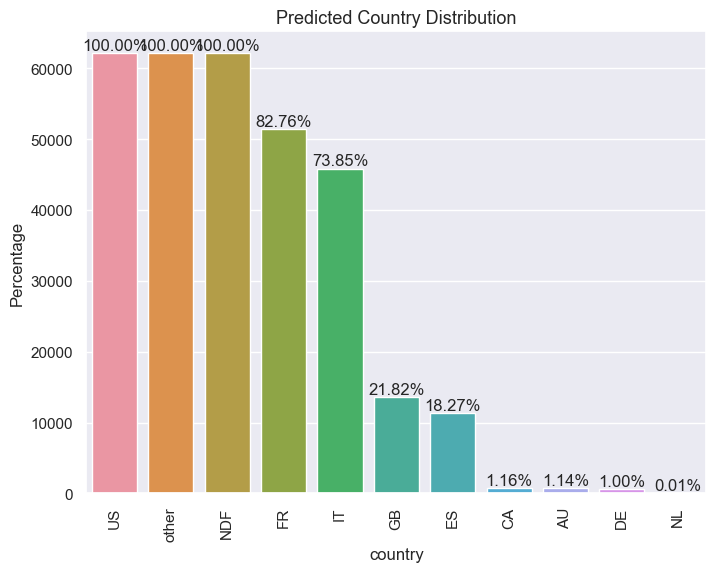

In [118]:
#test csv

# Load and preprocess the test data
test_data = pd.read_csv("../data/test_merge_tfidf.csv")

test_df = pd.read_csv('../data/test_users.csv')

test_id = test_df['id'].values

test_id

# https://www.kaggle.com/kevinwu06/feature-importance-w-xgboost

pred = clf.predict_proba(test_data[selected_feature_names])

ids = []
countries = []

# Taking the 5 classes with highest probabilities

for i in range(len(test_id)):
    idx = test_id[i]
    ids += [idx] * 5
    countries += le.inverse_transform(np.argsort(pred[i])[::-1][:5]).tolist()
    
# Generate submission

sub = pd.DataFrame({"id" : ids,"country" : countries})

sub.to_csv('../data/submission_XGBoost_new.csv', index = False)

import seaborn as sns
import matplotlib.pyplot as plt

# Create the countplot
sns.set(style="darkgrid")
plt.figure(figsize=(8, 6))  # Optional: Set the figure size

# Calculate percentages
total_samples = len(test_data)
ax = sns.countplot(x='country', data=sub, order=sub['country'].value_counts().index)

# Add percentages to the plot
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height/total_samples*100:.2f}%', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')

plt.title("Predicted Country Distribution", size=13)
plt.ylabel("Percentage")
plt.xticks(rotation=90)  # Optional: Rotate x-axis labels if needed
plt.show()

# Submission2

In [119]:
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import LabelEncoder

# # Load and preprocess the test data
# test_data = pd.read_csv("../data/test_merge_tfidf.csv")

In [120]:
# # Predict using the trained model
# test_predictions = clf.predict(test_data[selected_feature_names])

In [121]:
# test_predictions

In [122]:
# y['target_column_name']

In [123]:
# train_merge = y
# train_merge['country_destination'] = y['target_column_name'].astype('category')

# # Map predicted class labels to category codes
# test_data['predicted_country'] = pd.Categorical(test_predictions, categories=train_merge['country_destination'].cat.categories)

# test_data['predicted_country']

In [124]:
# test_data['predicted_country'].unique()

In [125]:
# test_data['predicted_country'].value_counts()

In [126]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Create the countplot
# sns.set(style="darkgrid")
# plt.figure(figsize=(8, 6))  # Optional: Set the figure size

# # Calculate percentages
# total_samples = len(test_data)
# ax = sns.countplot(x='predicted_country', data=test_data, order=test_data['predicted_country'].value_counts().index)

# # Add percentages to the plot
# for p in ax.patches:
#     height = p.get_height()
#     ax.annotate(f'{height/total_samples*100:.2f}%', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')

# plt.title("Predicted Country Distribution", size=13)
# plt.ylabel("Percentage")
# plt.xticks(rotation=90)  # Optional: Rotate x-axis labels if needed
# plt.show()

In [127]:
# submission = pd.read_csv("../data/sample_submission_NDF.csv")

# # Prepare submission file
# submission['country'] = test_data[['predicted_country']]

# submission.to_csv('../data/submission_XGBoost.csv', index=False)

# +

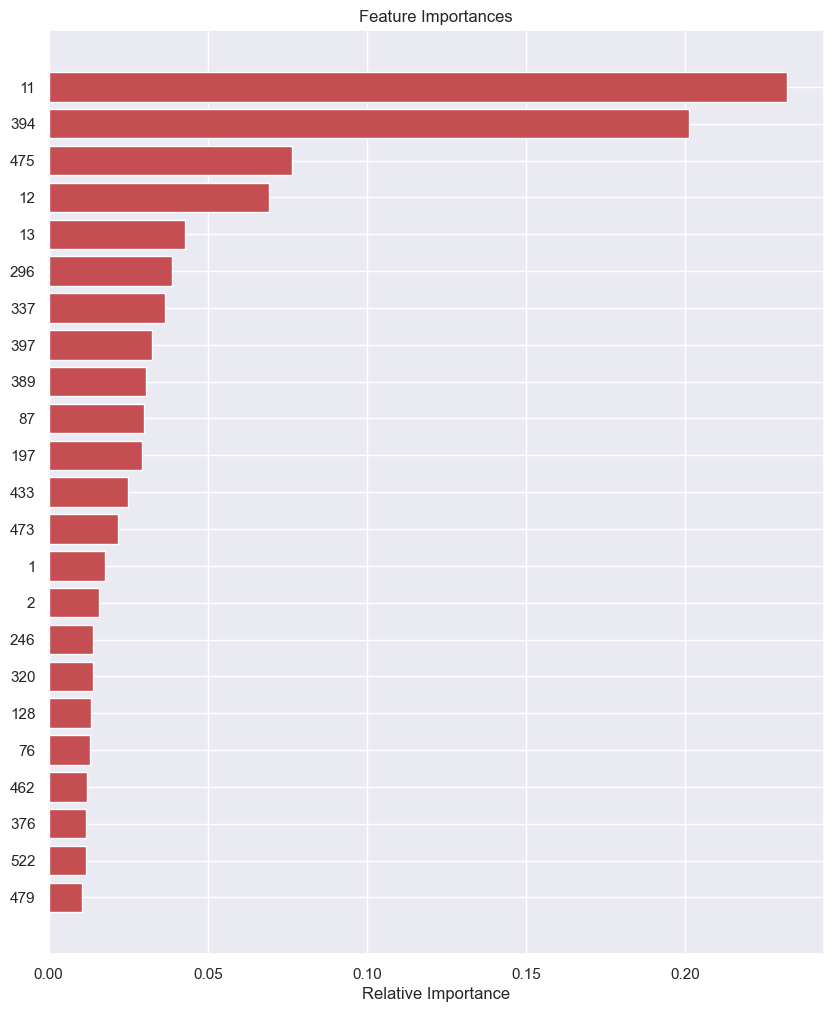

In [128]:
#feature importance

features = selected_feature_names
importances = clf.best_estimator_.feature_importances_

indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Select top 80% of the features

In [129]:
top_80 = int(len(clf.best_estimator_.feature_importances_)*0.8)

indices = (np.argsort(importances))[::-1][:top_80]

In [130]:
# Select the top features from the DataFrame X
X_new = X.iloc[:, indices]

# Create a list of the selected column names
col_lst_new = [selected_feature_names[i] for i in indices]

In [131]:
print("Final Data matrix")
print(X_new.shape)
print(y.shape)
print(len(col_lst_new))
print("="*100)

Final Data matrix
(20000, 18)
(20000, 1)
18


# Train on top 80% data

In [132]:
X_new

,11,394,475,12,13,296,337,397,389,87,197,433,473,1,2,246,320,128
0,0.0,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.026924,0.000000,0.0,0.0,0.000000,0.000000,0.0,3427529.0,0.000000,0.0,0.0
1,1.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,207842.0,0.000000,0.0,1.0
2,1.0,0.277931,0.245959,0.0,0.0,0.184353,0.191610,0.182801,0.156248,0.0,0.0,0.603652,0.251401,0.0,1135444.0,0.000000,0.0,0.0
3,1.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,3755100.0,0.000000,0.0,0.0
4,1.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.000000,25.0,2555.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.0,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.968912,0.000000,1.0,0.0,0.000000,0.000000,12.0,1648906.0,0.000000,0.0,0.0
19996,0.0,0.395995,0.215110,0.0,1.0,0.179678,0.933753,0.260454,0.152285,0.0,0.0,0.175980,0.879477,0.0,204751.0,0.000000,0.0,1.0
19997,1.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,896653.0,0.000000,0.0,0.0
19998,0.0,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,1014369.0,0.133594,0.0,1.0


In [133]:
y

,target_column_name
0,other
1,NDF
2,NDF
3,NDF
4,GB
...,...
19995,NDF
19996,US
19997,NDF
19998,NDF


In [134]:
clf.fit(X_new,y_target)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='mlogloss',
                                           feature_types=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rat...
                                                          0.2],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001C481AB4AC0>,
                                        'min_child_weight': [0.25, 0.5, 1.0,
                                                             3.0, 5.0, 7.0],
                                        'n_estimators': [100, 200, 500, 1000,
                                                         2000],
                                        'reg_lambda': [0.1, 0.2, 0.4, 0.5, 0.6,
                                                       0.8, 1.0, 10.0],
                                        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9,
                                                      1.0]},
                   random_state=42,
                   scoring=make_scorer(ndcg_score, needs_proba=True, k=5),
                   verbose=10)

In [135]:
pred_y = clf.predict_proba(X_new)

In [136]:
#Train ndcg score

s = ndcg_score(y_target, pred_y, k=5)

s

0.8637538207208653

# Evaluation

In [137]:
pred_y = clf.predict(X_new)

In [138]:
from sklearn.metrics import accuracy_score, classification_report

# Evaluate the model
accuracy = accuracy_score(y_target, pred_y)
report = classification_report(y_target, pred_y)

# Print the evaluation metrics
print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')

Accuracy: 0.69765
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        49
           1       0.00      0.00      0.00        82
           2       0.00      0.00      0.00        65
           3       0.00      0.00      0.00       185
           4       0.00      0.00      0.00       382
           5       0.00      0.00      0.00       179
           6       0.00      0.00      0.00       249
           7       0.71      0.94      0.81     12061
           8       0.00      0.00      0.00        61
           9       0.00      0.00      0.00        17
          10       0.64      0.45      0.53      5619
          11       0.94      0.02      0.03      1051

    accuracy                           0.70     20000
   macro avg       0.19      0.12      0.11     20000
weighted avg       0.66      0.70      0.64     20000



C:\Users\ayoub\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ayoub\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ayoub\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


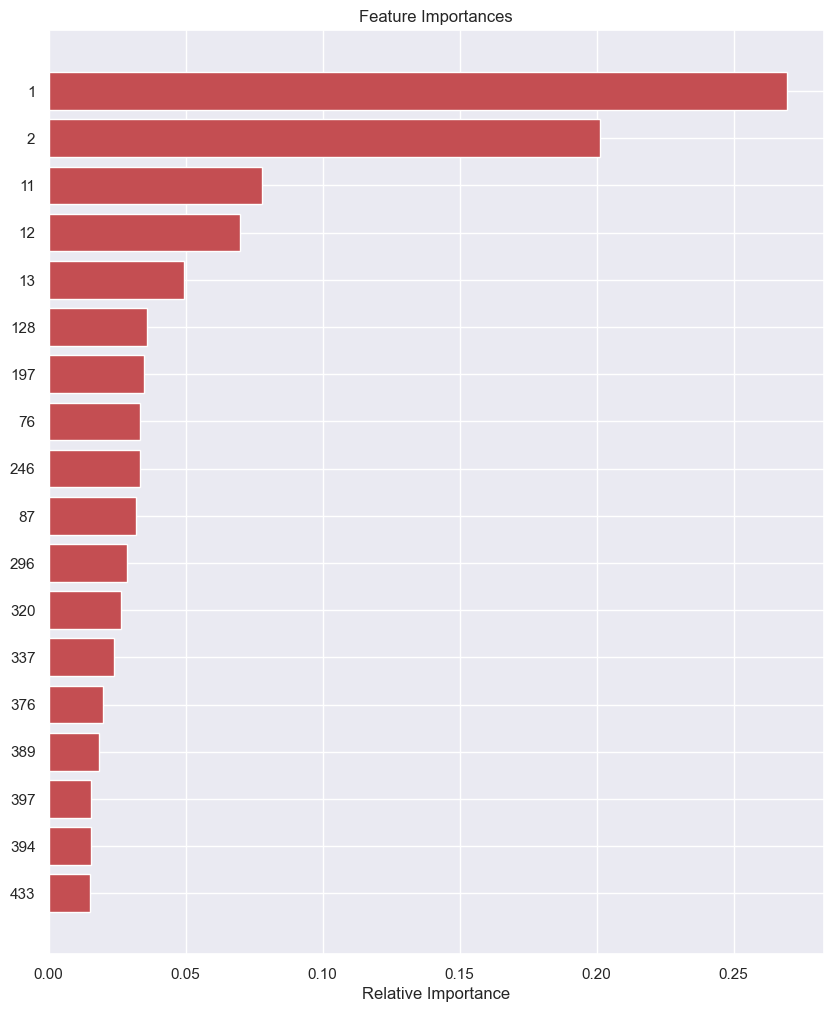

In [139]:
#feature importance

features = selected_feature_names
importances = clf.best_estimator_.feature_importances_

indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()